In [68]:
# We'll always import numpy
import numpy as np

# If you need plotting
import matplotlib.pyplot as plt

# Import these if you need to read data from synnax
import synnax as sy
from mcnugget.client import client

## Retrieving our data

In [105]:
# Retrieve the range containing our data. We can search for this using the
# synnax console.
data = client.ranges.retrieve("October 28 Gooster")

In [106]:
# This gives our channel a better name than the PT #
data.gse_pressure_20.set_alias("bottle_pressure")
data.gse_pressure_13.set_alias("scuba_pressure")

## Exploring our data

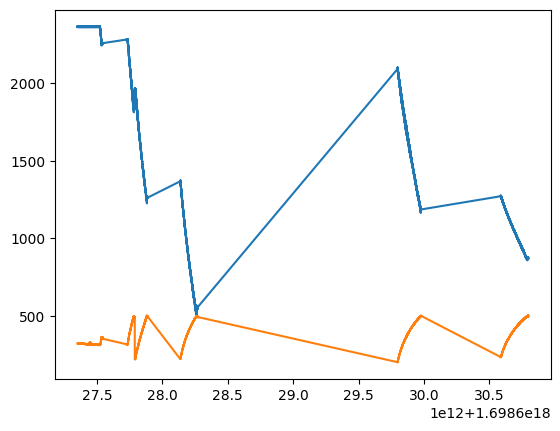

In [107]:
plt.plot(data.gse_time, data.bottle_pressure)
plt.plot(data.gse_time, data.scuba_pressure)

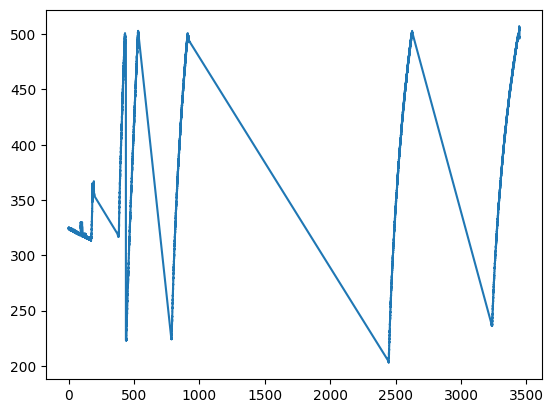

In [108]:
elapsed_time = sy.elapsed_seconds(data.gse_time)
plt.plot(elapsed_time, data.scuba_pressure)

## Splitting data into individual presses

In [109]:
# Split the data into sections where there is greater than 10 seconds between
# data points using numpy's split function
split_indexes = np.where(np.diff(elapsed_time) > 5)[0] + 1
split_data = np.split(data.scuba_pressure, split_indexes)
split_elapsed = np.split(elapsed_time, split_indexes)

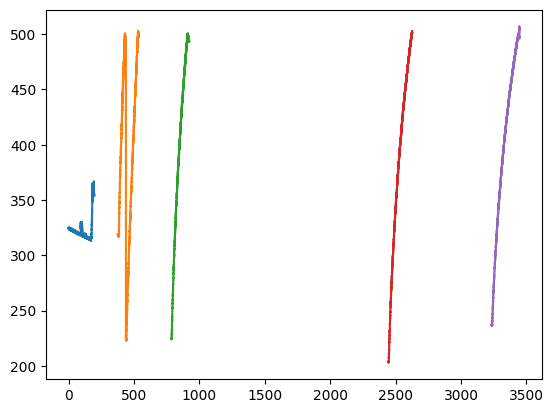

In [110]:
for i in range(len(split_data)):
    plt.plot(split_elapsed[i], split_data[i])


In [111]:
# Create a new named range named test {i + 1} for each split
split_time = np.split(data.gse_time, split_indexes)
ranges = list()
for i, d in enumerate(split_time):
    ranges.append(sy.Range(
        name=f"October 28 Gooster - Press {i + 1}",
        time_range=sy.TimeRange(d[0], d[-1]),
    ))
    
res_ranges = client.ranges.create(ranges, retrieve_if_name_exists=True)

ranges = { f"Press {i + 1}": r for i, r in enumerate(res_ranges) }

# Analyzing a press region

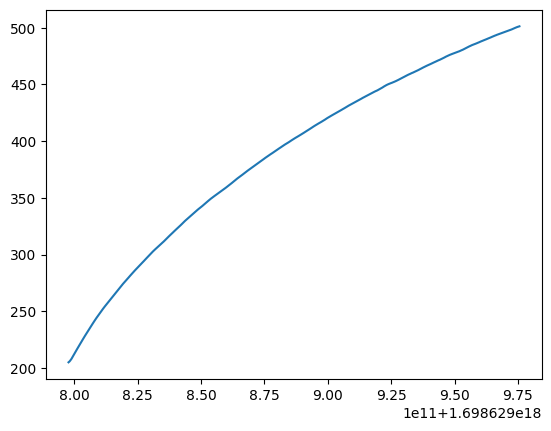

In [112]:
press_2 = ranges["Press 3"]
press_2.gse_pressure_20.set_alias("bottle_pressure")
press_2.gse_pressure_13.set_alias("scuba_pressure")

# We're interested in finding the region of the data where the scuba pressure climbs for more
# than 10 samples at a time
smoothed_scuba = np.convolve(press_2.scuba_pressure, np.ones(500)/500, mode="valid")
smoothed_time = np.convolve(press_2.gse_time, np.ones(500)/500, mode="valid")

plt.plot(smoothed_time, smoothed_scuba)

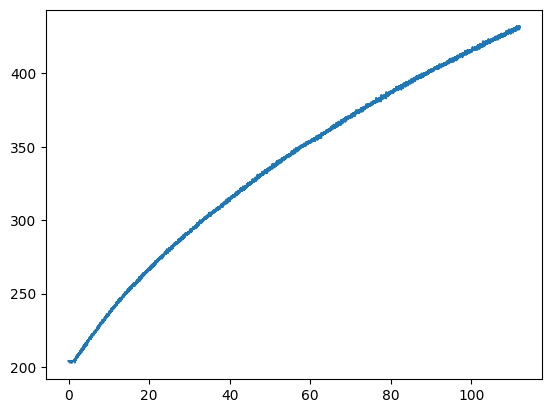

In [113]:
split_indexes = np.where(np.diff(smoothed_scuba) > 0)[0] + 1
split_indexes = np.split(split_indexes, np.where(np.diff(split_indexes) > 1)[0] + 1)
longest = max(split_indexes, key=len)
start, end = longest[0], longest[-1]
scuba = press_2.scuba_pressure[start:end]
time = sy.elapsed_seconds(press_2.gse_time[start:end])
plt.plot(time, scuba)

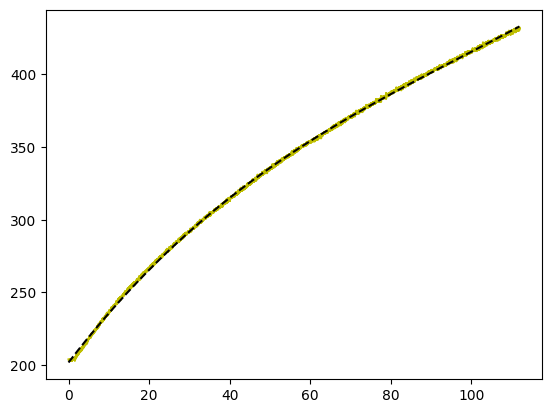

In [114]:
# use a quadratic regression to fit the curve
fit = np.polyfit(time, scuba, 3)
fit_fn = np.poly1d(fit)
plt.plot(time, scuba, 'y', time, fit_fn(time), '--k')

In [115]:
# Print out the fit equation
print(fit_fn)

          3           2
7.63e-05 x - 0.02224 x + 3.597 x + 201.9


# Comparing our presses

In [159]:
# Lets extract the above logic so we can generate a fit curve for all of our ranges
def fit(rng: sy.Range):
    rng.gse_pressure_20.set_alias("bottle_pressure")
    rng.gse_pressure_13.set_alias("scuba_pressure")
    SMOOTHING_FACTOR = np.ones(500)/500
    smoothed_scuba = np.convolve(rng.scuba_pressure, SMOOTHING_FACTOR, mode="valid")
    split_indexes = np.where(np.diff(smoothed_scuba) > 0)[0] + 1
    split_indexes = np.split(split_indexes, np.where(np.diff(split_indexes) > 1)[0] + 1)
    longest = max(split_indexes, key=len)
    start, end = longest[0], longest[-1]
    scuba = rng.scuba_pressure[start:end]
    # # subtract by min
    scuba = scuba - np.min(scuba)
    bottle = rng.bottle_pressure[start:end]
    time = sy.elapsed_seconds(rng.gse_time[start:end])
    fit = np.polyfit(time, scuba, 3)
    return np.poly1d(fit), time, scuba, bottle


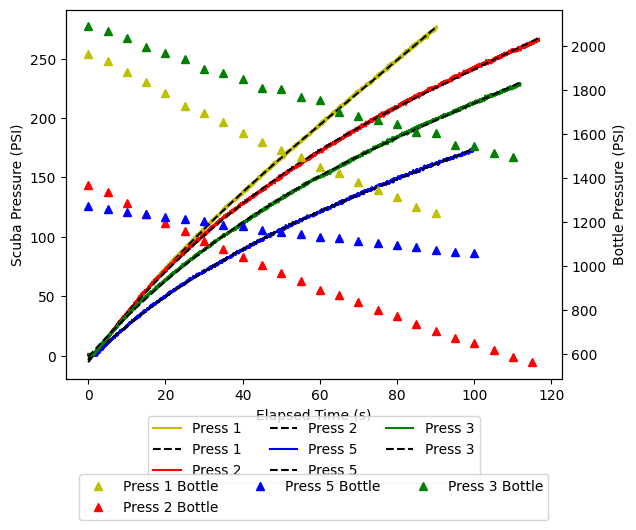

In [167]:
fit_1, fit_1_time, fit_1_scuba, fit_1_bottle = fit(ranges["Press 1"])
fit_2, fit_2_time, fit_2_scuba, fit_2_bottle = fit(ranges["Press 2"])
fit_5, fit_5_time, fit_5_scuba, fit_5_bottle = fit(ranges["Press 5"])
fit_3, fit_3_time, fit_3_scuba, fit_3_bottle = fit(ranges["Press 3"])

plt.plot(fit_1_time, fit_1_scuba, 'y', fit_1_time, fit_1(fit_1_time), '--k', label="Press 1")
plt.plot(fit_2_time, fit_2_scuba, 'r', fit_2_time, fit_2(fit_2_time), '--k', label="Press 2")
plt.plot(fit_5_time, fit_5_scuba, 'b', fit_5_time, fit_5(fit_5_time), '--k', label="Press 5")
plt.plot(fit_3_time, fit_3_scuba, 'g', fit_3_time, fit_3(fit_3_time), '--k', label="Press 3")

plt.xlabel("Elapsed Time (s)")
plt.ylabel("Scuba Pressure (PSI)")
# attach a legend to the bottom of the plot
plt.legend(loc="lower center", bbox_to_anchor=(0.5, -0.3), ncol=3)

ax2 = plt.twinx()

# Lets smooth out the bottle pressure to every 1000 samples
# get every 1000th sample
smoothed_bottle_1 = fit_1_bottle[::1000]
smoothed_bottle_1_time = fit_1_time[::1000]
smoothed_bottle_2 = fit_2_bottle[::1000]
smoothed_bottle_2_time = fit_2_time[::1000]
smoothed_bottle_5 = fit_5_bottle[::1000]
smoothed_bottle_5_time = fit_5_time[::1000]
smoothed_bottle_3 = fit_3_bottle[::1000]
smoothed_bottle_3_time = fit_3_time[::1000]


# plot as colored triangles
ax2.plot(smoothed_bottle_1_time, smoothed_bottle_1, "y^", label="Press 1 Bottle")
ax2.plot(smoothed_bottle_2_time, smoothed_bottle_2, "r^", label="Press 2 Bottle")
ax2.plot(smoothed_bottle_5_time, smoothed_bottle_5, "b^", label="Press 5 Bottle")
ax2.plot(smoothed_bottle_3_time, smoothed_bottle_3, "g^", label="Press 3 Bottle")


ax2.set_ylabel("Bottle Pressure (PSI)")
# attach a legend to the bottom of the plot
ax2.legend(loc="lower center", bbox_to_anchor=(0.5, -0.4), ncol=3)

Text(0.5, 1.0, 'Delta')

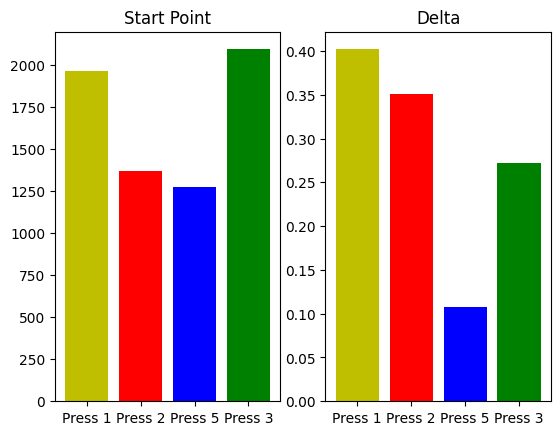

In [156]:
# make a bar chart of the bottle pressure start point and the bottle pressure delta
# for each press
press_names = ["Press 1", "Press 2", "Press 5", "Press 3"]
press_colors = ["y", "r", "b", "g"]
press_bottle = [fit_1_bottle, fit_2_bottle, fit_5_bottle, fit_3_bottle]

# get the start point of each press
press_start = [p[0] for p in press_bottle]
# get the average diff
press_delta = [np.abs(np.mean(np.diff(p))) * 10 for p in press_bottle]

fig = plt.figure()
# add two plots next to each other
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

# plot the start point and delta as a bar chart
ax1.bar(press_names, press_start, color=press_colors, label="Start")
ax1.set_title("Start Point")

# add a second plot
ax2.bar(press_names, press_delta, color=press_colors, label="Delta")
ax2.set_title("Delta")
